In [1]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
import tqdm

api = wandb.Api()
#sweep_id = "ax028kf6"  # lr too high
#sweep_id = "5uy2qtuy"  # lower lr (better)
sweep_id = "q9p2gxfv"   # final test (full depth)
sweep = api.sweep("lauro/mup_test/" + sweep_id)

In [2]:
# for run in sweep.runs:
#     nlayers = run.config['model_config']['num_layers']
#     if nlayers != 2:
#         print(run.name, run.state, run.config['model_config']['num_layers'])

# Load Wandb Data

In [3]:
wandb_data = []
for run in tqdm.tqdm(sweep.runs):
    if run.state == 'finished':
        wandb_data.append([
            run.config['d_model'],
            run.history(),
        ])

100%|██████████| 32/32 [00:22<00:00,  1.42it/s]


In [4]:
d, his = wandb_data[0]
his['_timestamp']

0    1.692277e+09
1    1.692277e+09
2    1.692277e+09
3    1.692277e+09
4    1.692277e+09
Name: _timestamp, dtype: float64

# Helper Functions

In [5]:
def get_act_data(timestep: int, name: str):
    act_data = {}
    for r in wandb_data:
        size, his = r
        stat = his[name][timestep]

        try: 
            act_data[size].append(stat)
        except KeyError:
            act_data[size] = [stat]
    return act_data


def get_means_and_stds(act_data):
    """
    act_data is a dictionary of lists of activations for each size, eg
    {
        100: [0.1, 0.2, 0.3], 
        200: [0.4, 0.5, 0.6]
    }
    """
    sizes = list(act_data.keys())
    means = np.array([np.mean(act_data[size]) for size in sizes])
    stds = np.array([np.std(act_data[size]) / np.sqrt(np.mean(act_data[size])) for size in sizes])

    sort_idx = np.argsort(sizes)
    sizes = np.array(sizes)[sort_idx]
    means = means[sort_idx]
    stds = stds[sort_idx]
    return sizes, means, stds


def plot_single(timestep: int, name: str, ax=None, title=None, **kwargs):
    """plot one lineplot of activation stats x model size"""
    act_data = get_act_data(timestep, name)
    sizes, means, stds = get_means_and_stds(act_data)

    if ax is None:
        ax = plt.gca()

    ax.plot(sizes, means, "-o", **kwargs)
    ax.fill_between(sizes, means - stds, means + stds, alpha=0.5)
    ax.set_xlabel('Model Size')
#    ax.set_ylabel('L1 of Activations')
#    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_title(title)

# Plot

In [6]:
def get_name(
        prefix="train/",
        layer: int = 0,
        layertype: str = "residual_pre_attention",
        metric: str = "l1",
    ) -> str:
    """layertype can be pre_attention or pre_mlp"""
    return f"{prefix}activation_stats/layer_{layer}.{layertype}.{metric}"


def plot_timestep(timestep: int = 0, layer: int = 0, layertype: str = "pre_attention", ax=None):
    if ax is None:
        ax = plt.gca()
    if timestep == 0:
        prefix = "val/"
    else:
        prefix = "train/"

    target = get_name(prefix=prefix, layer=layer, layertype=layertype)
    title = f"Timestep {timestep}, Type {layertype}"
    if prefix == "val/":
        title += " (Validation)"
    plot_single(timestep, target, ax=ax, title=title, label=f"Layer {layer}")


def plot_triple(timesteps = [1,2,3], layer: int = 0, layertype: str = "pre_attention", axs=None):
    if axs is None:
        _, axs = plt.subplots(1, 3, figsize=(20, 4))
    for i, t in enumerate(timesteps):
        plot_timestep(t, layer=layer, layertype=layertype, ax=axs[i])
        axs[i].legend()

In [7]:
# print columns
cols = [col for col in wandb_data[0][1].columns if "train/" in col and "l1" in col and "layer_0" in col]
cols = sorted(cols)
print(*cols, sep='\n')

train/activation_stats/layer_0.attention.attention.l1
train/activation_stats/layer_0.attention.key.l1
train/activation_stats/layer_0.attention.logits.l1
train/activation_stats/layer_0.attention.query.l1
train/activation_stats/layer_0.attention.value.l1
train/activation_stats/layer_0.attention_out.l1
train/activation_stats/layer_0.mlp_mid.l1
train/activation_stats/layer_0.mlp_out.l1
train/activation_stats/layer_0.residual_pre_attention.l1
train/activation_stats/layer_0.residual_pre_mlp.l1


In [8]:
FIGSIZE = (20, 6)

## Residual Activations

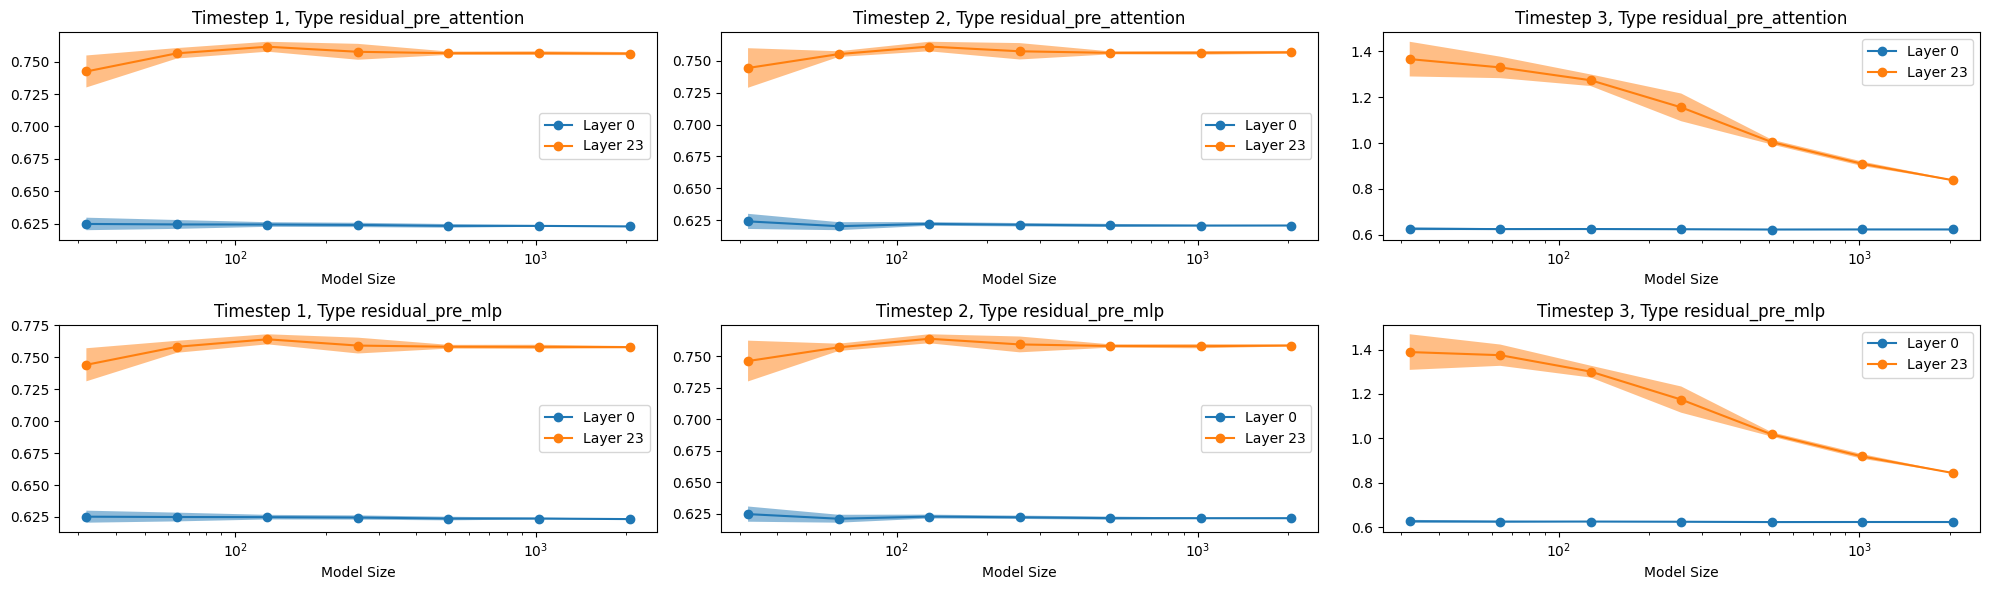

In [15]:
_, axs = plt.subplots(2, 3, figsize=FIGSIZE)
plot_triple(layer=0, layertype="residual_pre_attention", axs=axs[0])
plot_triple(layer=23, layertype="residual_pre_attention", axs=axs[0])

plot_triple(layer=0, layertype="residual_pre_mlp", axs=axs[1])
plot_triple(layer=23, layertype="residual_pre_mlp", axs=axs[1])

plt.tight_layout()

## Attention

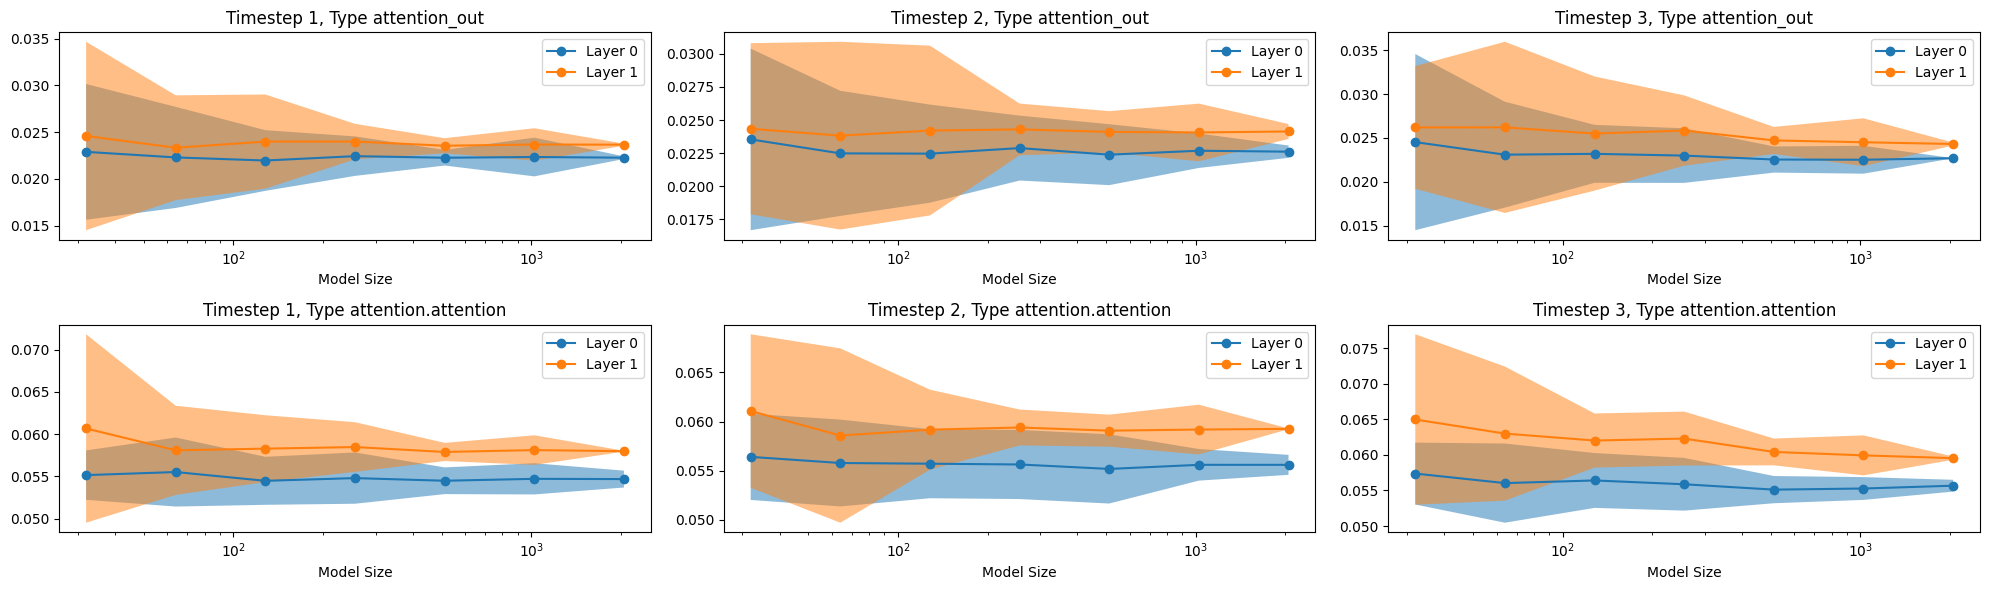

In [10]:
_, axs = plt.subplots(2, 3, figsize=(20, 6))
plot_triple(layer=0, layertype="attention_out", axs=axs[0])
plot_triple(layer=1, layertype="attention_out", axs=axs[0])


plot_triple(layer=0, layertype="attention.attention", axs=axs[1])
plot_triple(layer=1, layertype="attention.attention", axs=axs[1])

plt.tight_layout()

#for ax in axs:
#    ax.set_yscale("log")

## MLP Activations

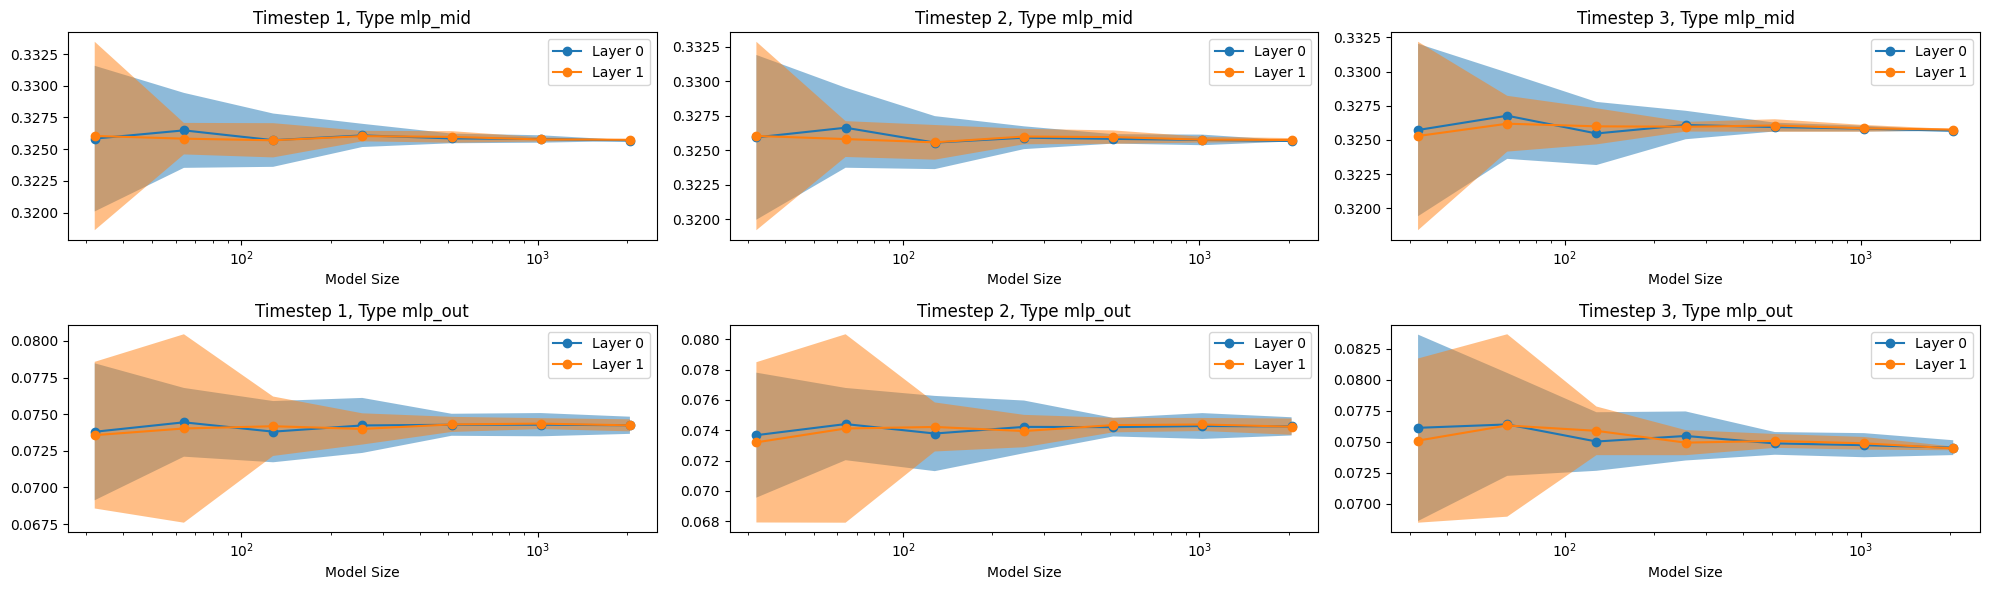

In [11]:
_, axs = plt.subplots(2, 3, figsize=FIGSIZE)
plot_triple(layer=0, layertype="mlp_mid", axs=axs[0])
plot_triple(layer=1, layertype="mlp_mid", axs=axs[0])

plot_triple(layer=0, layertype="mlp_out", axs=axs[1])
plot_triple(layer=1, layertype="mlp_out", axs=axs[1])

plt.tight_layout()

# Output

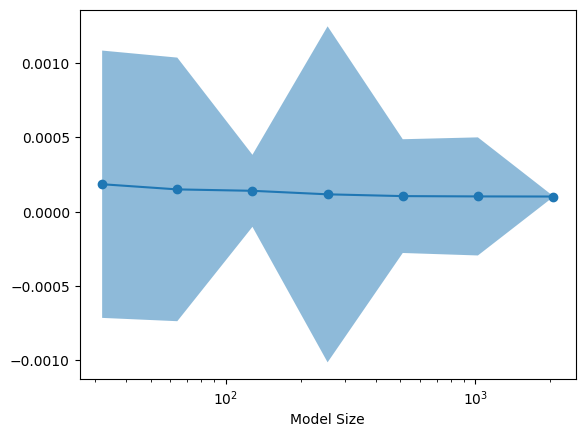

In [12]:
# only makes sense to plot for timestep 2 (bc otherwise zero)
plot_single(2, "train/activation_stats/output")
plt.yscale("linear")